# Daily Probability of Meeting Someone With COVID-19 in Puerto Rico (CCOM 3031 Project)

**Output**: Python notebook

**Documentation**: [Google document](https://docs.google.com/document/d/1F_T1m6ssFgTyEOdtPctYF6wSlt-k85PdKmj9CnLaeUI/edit?usp=sharing)

**Date**: 12 - 18 - 2020

**Authors**: 

*   **Facilitator**: Omar Durand Ortiz
*   **Spokesperson**: Ildefonso Pacheco Torres
*   **Quality Control**: Lian M. Pérez Sierra
*   **Process Analyst**: Miguel E. Cruz MolinaL


## Introduction:

The following notebook contains the code that comprises our calculations and attempt to answer the titular question: What is the probability of meeting someone afflicted with Covid-19 in Puerto Rico? Inspired by Marek Galovič's article ["How likely are you to meet someone with Coronavirus?"](https://towardsdatascience.com/how-likely-are-you-to-meet-someone-with-coronavirus-4522d39487b7), our analysis calculates this probability by using the formula $\small 1 - (1 - P(positive))$, where $\small P(positive)$ is the probability of having the virus. As in Galovič's analysis, our results follow two different statistical approaches towards calculating $\small P(positive)$, one frequentist and the other Bayesian.

As with most other data science endeavours, this project is comprised by distinct parts devoted to data collection, processing and visualization. Our calculations employ the data recorded by the John Hopkins University of Medicine's [Coronavirus Resource Center](https://coronavirus.jhu.edu/region/us/puerto-rico) for Puerto Rico, which is updated on a daily basis with the exact amounts of new confirmed cases and deaths and total number of tests recorded on the island since the March, 16th. Previous attempts were made to use the data collected by the [Centers of Desease Control and Prevention](https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36), but said database was eventually considered inadequate, as it didn't include the daily count of negative cases and thus couldn't be used to calculate $\small P(positive)$. Both dataset extraction processes can be found below.

Finally, after calculating $\small P(positive)$ under both statistical approaches for our dataset, our analysis ends with calculating and displaying the titular probability in two different ways: (1.) plotting the frequentist and Bayesian probabilities of meeting someone with Covid-19 in a group of size $\small N$, given the probability of having Covid-19 for the last day in the database (i.e., today), and (2.) plotting the probabilities by time (all the entries in the database from the last to the most recent) for fixed group sizes 3, 6, 9, 12 and 50.

## Setup Process:

Install sodapy library used in the code if necessary:

In [1]:
!pip install sodapy

Import relevant libraries:

In [6]:
from sodapy import Socrata
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

## Data extraction and cleaning of old (CDC) dataset:

Population of Puerto Rico: 

In [117]:
population = 3193694

Read data from CDC:

In [118]:
df = pd.read_json("https://data.cdc.gov/resource/9mfq-cb36.json?state=PR")

Confirm that PR is the only state included in the data:

In [119]:
df.state.unique()

array(['PR'], dtype=object)

Sort values by submission date:

In [120]:
df.sort_values(by = 'submission_date', inplace = True)

Replace all null values:

* First, with the previous values for each variable in the data frame.

* In the case of the number of *confirmed cases*, which would otherwise stay as null in the first few rows, replace it with the number of *total cases* for all those rows. 

* In the case of the number of *probable cases*, do the same, replacing it with the number of total cases minus the number of confirmed cases for all rows where it is null.

This procedure stems from the presumption that (1.) once these variables started being counted, the counts for rows with null values must have stayed the same than that of the previous rows (this is only true for accumulative variables, i.e. `tot_cases`, `conf_cases`, `prob_cases`, `tot_death`, `conf_death`, and `prob_death`) and (2.) before a distinction was made between confirmed and probable cases, every recorded case was treated as a confirmed case.

In [121]:
df = df.fillna(method = 'ffill')

df['conf_cases'] = df['conf_cases'].fillna(df['tot_cases']) 
df['prob_cases'] = df['prob_cases'].fillna(df['tot_cases'] - df['conf_cases'])

Examine first 5 rows and last 5 rows:

In [122]:
df.head(5)

,submission_date,state,tot_cases,new_case,tot_death,new_death,created_at,consent_cases,consent_deaths,conf_cases,prob_cases,pnew_case,conf_death,prob_death,pnew_death
134,2020-01-22T00:00:00.000,PR,0,0,0,0,2020-03-26 16:22:39.452,Agree,Agree,0.0,0.0,NaN,NaN,NaN,NaN
217,2020-01-23T00:00:00.000,PR,0,0,0,0,2020-03-26 16:22:39.452,Agree,Agree,0.0,0.0,NaN,NaN,NaN,NaN
63,2020-01-24T00:00:00.000,PR,0,0,0,0,2020-03-26 16:22:39.452,Agree,Agree,0.0,0.0,NaN,NaN,NaN,NaN
185,2020-01-25T00:00:00.000,PR,0,0,0,0,2020-03-26 16:22:39.452,Agree,Agree,0.0,0.0,NaN,NaN,NaN,NaN
0,2020-01-26T00:00:00.000,PR,0,0,0,0,2020-03-26 16:22:39.452,Agree,Agree,0.0,0.0,NaN,NaN,NaN,NaN


In [123]:
df.tail(5)

,submission_date,state,tot_cases,new_case,tot_death,new_death,created_at,consent_cases,consent_deaths,conf_cases,prob_cases,pnew_case,conf_death,prob_death,pnew_death
152,2020-12-16T00:00:00.000,PR,64751,1065,1323,11,2020-12-17 14:33:42.543,Agree,Agree,61783.0,2968.0,74.0,1086.0,237.0,2.0
8,2020-12-17T00:00:00.000,PR,66132,1381,1333,10,2020-12-18 14:45:01.331,Agree,Agree,63075.0,3057.0,89.0,1094.0,239.0,2.0
119,2020-12-18T00:00:00.000,PR,67211,1079,1342,9,2020-12-19 14:42:31.925,Agree,Agree,64182.0,3029.0,-28.0,1102.0,240.0,1.0
258,2020-12-19T00:00:00.000,PR,68433,1222,1368,26,2020-12-20 14:32:33.200,Agree,Agree,64697.0,3736.0,707.0,1125.0,243.0,3.0
249,2020-12-20T00:00:00.000,PR,68849,416,1382,14,2020-12-21 14:39:53.673,Agree,Agree,65064.0,3785.0,49.0,1141.0,241.0,-2.0


Examine characteristics of the dataset: 

In [124]:
df.describe()

,tot_cases,new_case,tot_death,new_death,conf_cases,prob_cases,pnew_case,conf_death,prob_death,pnew_death
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,246.000000,246.000000,246.000000,246.000000
mean,21499.152695,206.134731,359.221557,4.137725,13577.700599,7921.452096,15.386179,350.894309,134.178862,0.979675
std,23230.484405,1877.131483,387.352001,5.114211,17791.163600,10135.749272,2177.234727,317.458101,66.638107,3.527674
min,0.000000,-33355.000000,0.000000,0.000000,0.000000,0.000000,-33864.000000,56.000000,0.000000,-11.000000
25%,935.750000,24.250000,46.500000,0.000000,935.750000,0.000000,33.750000,63.000000,90.500000,0.000000
50%,8729.500000,129.000000,158.000000,2.000000,2757.500000,2579.000000,102.000000,238.000000,132.500000,0.000000
75%,42478.250000,531.250000,652.500000,7.000000,23690.000000,14722.750000,227.250000,589.000000,183.750000,1.000000
max,71455.000000,1947.000000,1382.000000,26.000000,65064.000000,33965.000000,1959.000000,1141.000000,246.000000,51.000000


Calculate frenquentist and Bayesian results of `P(positive)` for all rows of the dataset (these formulas are explained in more detail in the "Probability of meeting someone with Covid-19 in Puerto Rico" section:

In [125]:
df['freq_pos'] = df['conf_cases']/population

In [126]:
df['bayes_pos'] = 2*df['freq_pos']

## Data extraction and cleaning of new (John Hopkins) dataset:

Population of Puerto Rico: 

In [28]:
population = 3193694

Read statistics with total tested population (positive and negative) in Puerto Rico from using John Hopkins API:

In [29]:
df_test = pd.read_json("https://api.covidtracking.com/v1/states/pr/daily.json")

Modify `date` variable to contain Date objects in the format `year-month-day`, instead of integers:

In [30]:
newdates = []

for index, row in df_test.iterrows():
  date = datetime.date(year  = int(str(row['date'])[0:4]),
                       month = int(str(row['date'])[4:6]),
                       day   = int(str(row['date'])[6:8]))
  newdates.append(date)

df_test['date'] = newdates

Sort the data by date, from the first day recorded to the last:

In [31]:
df_test.sort_values(by = 'date', inplace = True)

See the first five rows of the dataframe and the last five:

In [32]:
df_test.head(5)

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestEncountersViral,totalTestsPeopleViral,totalTestsAntibody,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
279,2020-03-16,PR,5,NaN,9.0,NaN,posNeg,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,3/16/2020 15:44,2020-03-16T15:44:00Z,03/16 11:44,NaN,NaN,2020-03-16T15:44:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,0,0,14,0,14,0,0,fe077c5e3c595b45d18fb0f097cd9b98d719fa7e,0,0,0,0,0,
278,2020-03-17,PR,5,NaN,13.0,4.0,posNeg,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,3/17/2020 15:41,2020-03-17T15:41:00Z,03/17 11:41,NaN,NaN,2020-03-17T15:41:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,0,4,22,4,18,0,0,9fdeef6f35b99fba0007a978631d4968c5b7da15,0,0,0,0,0,
277,2020-03-18,PR,5,NaN,31.0,21.0,posNeg,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,3/17/2020 22:00,2020-03-17T22:00:00Z,03/17 18:00,NaN,NaN,2020-03-17T22:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,0,18,57,18,36,0,0,7e2772b6d5f3a4f32c5008d7c9f32e55296af442,0,0,0,0,0,
276,2020-03-19,PR,5,NaN,56.0,29.0,posNeg,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,3/19/2020 07:50,2020-03-19T07:50:00Z,03/19 03:50,NaN,NaN,2020-03-19T07:50:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,0,25,90,25,61,0,0,d4bf72adb6f7f817bdd2c56adb99aef8d25131b9,0,0,0,0,0,
275,2020-03-20,PR,14,NaN,114.0,52.0,posNeg,128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,3/20/2020 13:00,2020-03-20T13:00:00Z,03/20 09:00,NaN,NaN,2020-03-20T13:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,9,58,180,67,128,0,0,9a4f4775accc09ece73768764ab3954b725a30e4,0,0,0,0,0,


In [33]:
df_test.tail(5)

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestEncountersViral,totalTestsPeopleViral,totalTestsAntibody,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
4,2020-12-16,PR,63686,2894.0,305972.0,NaN,posNeg,369658,593.0,NaN,98.0,NaN,96.0,NaN,55464.0,B,12/16/2020 00:00,2020-12-16T00:00:00Z,12/15 19:00,1312.0,NaN,2020-12-16T00:00:00Z,310546.0,7002.0,303412.0,60792.0,1077.0,235.0,NaN,NaN,NaN,47546.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,267,0,369658,267,369658,18,0,5e658de3c995662bd95b62a03bf75533ce87c62e,0,0,0,0,0,
3,2020-12-17,PR,64751,2968.0,305972.0,NaN,posNeg,370723,602.0,NaN,99.0,NaN,100.0,NaN,55479.0,B,12/17/2020 00:00,2020-12-17T00:00:00Z,12/16 19:00,1323.0,NaN,2020-12-17T00:00:00Z,310546.0,7002.0,303412.0,61783.0,1086.0,237.0,NaN,NaN,NaN,48083.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,1065,0,370723,1065,370723,11,0,61f42bcc02694de9a91a19b9b177fd4698252399,0,0,0,0,0,
2,2020-12-18,PR,66132,3057.0,305972.0,NaN,posNeg,372104,575.0,NaN,97.0,NaN,96.0,NaN,55628.0,B,12/18/2020 00:00,2020-12-18T00:00:00Z,12/17 19:00,1333.0,NaN,2020-12-18T00:00:00Z,310546.0,7002.0,303412.0,63075.0,1094.0,239.0,NaN,NaN,NaN,49060.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,1381,0,372104,1381,372104,10,0,c3f8cab58c3b1e6d170d116190289d9aac151d66,0,0,0,0,0,
1,2020-12-19,PR,67211,3029.0,305972.0,NaN,posNeg,373183,558.0,NaN,97.0,NaN,106.0,NaN,55964.0,B,12/19/2020 00:00,2020-12-19T00:00:00Z,12/18 19:00,1342.0,NaN,2020-12-19T00:00:00Z,310546.0,7002.0,303412.0,64182.0,1102.0,240.0,NaN,NaN,NaN,49859.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,1079,0,373183,1079,373183,9,0,1d8e0273fa3d493a292383e8a742f70b7c6851fe,0,0,0,0,0,
0,2020-12-20,PR,68433,3736.0,305972.0,NaN,posNeg,374405,540.0,NaN,94.0,NaN,101.0,NaN,55454.0,B,12/20/2020 00:00,2020-12-20T00:00:00Z,12/19 19:00,1368.0,NaN,2020-12-20T00:00:00Z,310546.0,7002.0,303412.0,64697.0,1125.0,243.0,NaN,NaN,NaN,50177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,1222,0,374405,1222,374405,26,0,5ad7fc9ce84f2607ee3ad5d68dacfcfcd99acdb1,0,0,0,0,0,


## Probability of meeting someone with Covid-19 in Puerto Rico:


The probability of encountering someone with Covid-19 in any one day is assumed to be the probability of someone in a group of $\small N$ people having the virus, calculated as $\small 1 - (1 - P(positive))^N$. As mentioned in the introduction, our study considers two different statistical approaches to finding the corresponding value of $\small P(positive)$ for each day: one frequentist, the other Bayesian. 

### Frequentist approach to calculating $\small P(positive)$: 

Using the frequentist approach, the probability is calculated by dividing the number of recorded positive (or "active") cases by the total size of the population of Puerto Rico.

In [34]:
df_test['frequentist'] = df_test['positive']/population
#df_test.tail(5)

**Frequentist value of $\small P(positive)$ for today**:

Since the data frame is ordered from the first to the most recent day recorded, and we assume that the dataset is continuously being updated, the probability $\small P(positive)$ under the frequentist approach is the probability recorded in the last row of the data frame:

In [35]:
freq_prob = df_test.iloc[-1].at['frequentist']
print(freq_prob)

0.021427538142351772


### Bayesian approach to calculating $\small P(positive)$: 

Under the Bayesian approach, the probability of being positive to Covid-19 is calculated as $\small P(positive) = P(positive|tested) \times P(tested) / P(tested|positive)$. In this context, $\small P(positive|tested)$ is the number of confirmed cases divided by the total of cases, and $\small P(tested)$ is the number of total tests divided by the population of Puerto Rico. Thus, the numerator of the formula is reduced to the number of confirmed cases over the total population, the same as the frequentist probability. The denominator is chosen to be $\small 0.5$, with the somewhat pessimistic assumption that only half of the people with Covid-19 will get tested for the virus. Therefore, the original formula is simplified as `2 * freq_prob`. 

In [37]:
df_test['bayesian'] = 2*df_test['frequentist']
#df_test.tail(5)

**Bayesian value of $\small P(positive)$ for today**:

As before, the probability $\small P(positive)$ under the Bayesian approach is the probability recorded in the last row of the data frame:

In [38]:
bayes_prob = df_test.iloc[-1].at['bayesian']
print(bayes_prob)

0.042855076284703544


### Plotting the probability by group size for today:

Having extracted the values of $\small P(positive)$ for today for both statistical approaches, we can now calculate and plot the titular probability for group sizes 1 through 200. We do this by building a new data frame with the group sizes, adding the probabilities, and plotting them on a single graph.

Creating group size data frame:

In [39]:
group_size = list(range(1,201))
group_size_df = pd.DataFrame(group_size)
group_size_df = group_size_df.rename(columns={0: 'group_size'})

Calculating the probability by group size, using the frequentist approach:

In [40]:
group_size_df['Freq_Prob'] = (1 - (1 - freq_prob)**group_size_df['group_size'])*100
#print(group_size_df)
#plt.plot(group_size_df['group_size'], group_size_df['Freq_Prob'])

Calculating the probability by group size, using the Bayesian approach:

In [41]:
group_size_df['Bayes_Prob'] = (1 - (1 - bayes_prob)**group_size_df['group_size'])*100
#print(group_size_df)
#plt.plot(group_size_df['group_size'], group_size_df['Bayes_Prob'])

Plot the probability of coming into contact with someone with Covid-19 in a group of size $\small N$, given the probability of someone having Covid-19 calculated for today under both the frequentist and Bayesian approaches:

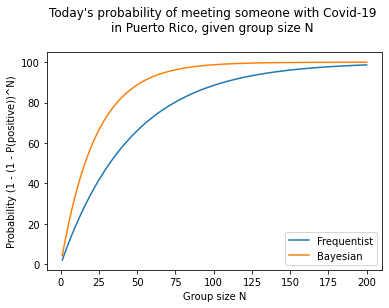

In [42]:
fig, ax = plt.subplots()

ax.plot(group_size_df['group_size'], group_size_df['Freq_Prob'])
ax.plot(group_size_df['group_size'], group_size_df['Bayes_Prob'])

ax.set_xlabel("Group size N")
ax.set_ylabel("Probability (1 - (1 - P(positive))^N)")
ax.set_title('''Today's probability of meeting someone with Covid-19 
in Puerto Rico, given group size N \n''')
plt.legend(['Frequentist', 'Bayesian'])

plt.show()
plt.close()

### Plotting the probability by time for a range of fixed group sizes:

Having calculated the values of $\small P(positive)$ for all the entries (days) in the dataset, we can also calculate and plot the daily increment in the probabilities of someone having Covid-19 in a group of fixed size. For this project, we generate the plots for groups of sizes 3, 6, 9, 12 and 50. We also allow the user to display in each plot the dates when 16 executive orders concerning the virus were passed in Puerto Rico, further dividing them between those that increased, decreased or extended previous state-enforced restrictions and lockdown measures. 

Group together the dates and ID numbers of the executive orders by which of them increased, decreased or extended previous restrictions:

In [90]:
# Executive orders that increased restrictions: 020, 029, 038, 054, 080, 087, 093

More_restr_EO = [("2020-03-15", "020"), ("2020-03-30", "029"), ("2020-05-01", "038"), ("2020-07-16", "054"), 
                 ("2020-11-13", "080"), ("2020-12-03", "087"), ("2020-12-18", "093")]

# Executive orders that decreased restrictions: 041, 044, 048, 062

Less_restr_EO = [("2020-05-21", "041"), ("2020-06-12", "044"), ("2020-06-29", "048"), ("2020-08-22", "062")]

# Executive orders that extended previous restrictions: 033, 060, 066, 076, 077

Same_restr_EO = [("2020-04-12", "033"), ("2020-08-01", "060"), ("2020-09-11", "066"), 
                 ("2020-10-01", "076"), ("2020-10-16", "077")]

Decide whether to display the datetimes of the executive orders in the following plots, defined by the Boolean variable `show_EOs` 

In [115]:
show_EOs = True

Plot the daily increase in the probability of coming into contact with someone with Covid-19 in a group of **size 3**:

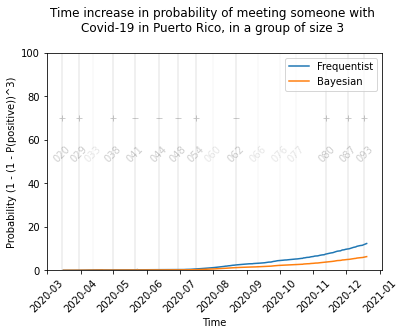

In [116]:
# Calculate daily probabilities by both approaches:

probs_3 = []
for index, row in df_test.iterrows(): 
  probs_3.append((1 - (1 - row['frequentist'])**3)*100)
for index, row in df_test.iterrows():
  probs_3.append((1 - (1 - row['bayesian'])**3)*100)

# Plot probabilites by time:

fig, ax = plt.subplots()
ax.plot(df_test['date'], probs_3[len(df_test['date']):])
ax.plot(df_test['date'], probs_3[:len(df_test['date'])])

# Set axis labels and title of the graph:

ax.set_xlabel("Time")
ax.set_ylabel("Probability (1 - (1 - P(positive))^3)")
ax.set_title('''Time increase in probability of meeting someone with 
Covid-19 in Puerto Rico, in a group of size 3 \n''')

# Set y-axis limits, rotate x-axis ticks and insert legend:

plt.ylim(0, 100)
plt.xticks(rotation = 45)
plt.legend(['Frequentist', 'Bayesian'])

# Show lines marking the date of each executive order, its ID # and whether
#   it increased ('+'), decreased ('_') or continued previous restrictions:

if show_EOs:
  for EO in More_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-' , color = 'grey', alpha = 0.15) 
    plt.plot(pd.to_datetime(EO[0]), 70, marker = '+', color = 'black', alpha = 0.20)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.20)
  for EO in Less_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-' , color = 'grey', alpha = 0.15)
    plt.plot(pd.to_datetime(EO[0]), 70, marker = '_', color = 'black', alpha = 0.20)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.20)
  for EO in Same_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-', color = 'grey', alpha = 0.05)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.10)
    
# Show and close plot:

plt.show()
plt.close()

Plot the daily increase in the probability of coming into contact with someone with Covid-19 in a group of **size 6**:

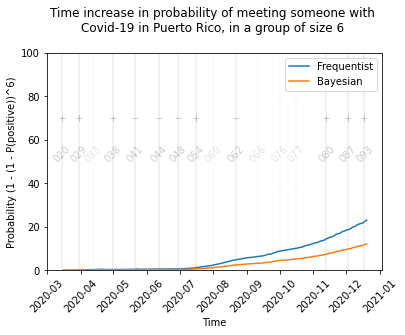

In [107]:
# Calculate daily probabilities by both approaches:

probs_6 = []
for index, row in df_test.iterrows(): 
  probs_6.append((1 - (1 - row['frequentist'])**6)*100)
for index, row in df_test.iterrows():
  probs_6.append((1 - (1 - row['bayesian'])**6)*100)

# Plot probabilites by time:

fig, ax = plt.subplots()
ax.plot(df_test['date'], probs_6[len(df_test['date']):])
ax.plot(df_test['date'], probs_6[:len(df_test['date'])])

# Set axis labels and title of the graph:

ax.set_xlabel("Time")
ax.set_ylabel("Probability (1 - (1 - P(positive))^6)")
ax.set_title('''Time increase in probability of meeting someone with 
Covid-19 in Puerto Rico, in a group of size 6 \n''')

# Set y-axis limits, rotate x-axis ticks and insert legend:

plt.ylim(0, 100)
plt.xticks(rotation = 45)
plt.legend(['Frequentist', 'Bayesian'])

# Show lines marking the date of each executive order, its ID # and whether
#   it increased ('+'), decreased ('_') or continued previous restrictions:

if show_EOs:
  for EO in More_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-' , color = 'grey', alpha = 0.15) 
    plt.plot(pd.to_datetime(EO[0]), 70, marker = '+', color = 'black', alpha = 0.20)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.20)
  for EO in Less_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-' , color = 'grey', alpha = 0.15)
    plt.plot(pd.to_datetime(EO[0]), 70, marker = '_', color = 'black', alpha = 0.20)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.20)
  for EO in Same_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '--', color = 'grey', alpha = 0.05)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.10)
    
# Show and close plot:

plt.show()
plt.close()

Plot the daily increase in the probability of coming into contact with someone with Covid-19 in a group of **size 9**:

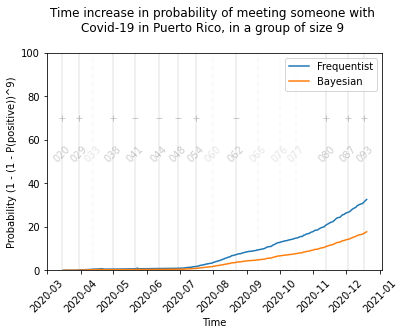

In [108]:
# Calculate daily probabilities by both approaches:

probs_9 = []
for index, row in df_test.iterrows(): 
  probs_9.append((1 - (1 - row['frequentist'])**9)*100)
for index, row in df_test.iterrows():
  probs_9.append((1 - (1 - row['bayesian'])**9)*100)

# Plot probabilites by time:

fig, ax = plt.subplots()
ax.plot(df_test['date'], probs_9[len(df_test['date']):])
ax.plot(df_test['date'], probs_9[:len(df_test['date'])])

# Set axis labels and title of the graph:

ax.set_xlabel("Time")
ax.set_ylabel("Probability (1 - (1 - P(positive))^9)")
ax.set_title('''Time increase in probability of meeting someone with 
Covid-19 in Puerto Rico, in a group of size 9 \n''')

# Set y-axis limits, rotate x-axis ticks and insert legend:

plt.ylim(0, 100)
plt.xticks(rotation = 45)
plt.legend(['Frequentist', 'Bayesian'])

# Show lines marking the date of each executive order, its ID # and whether
#   it increased ('+'), decreased ('_') or continued previous restrictions:

if show_EOs:
  for EO in More_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-' , color = 'grey', alpha = 0.15) 
    plt.plot(pd.to_datetime(EO[0]), 70, marker = '+', color = 'black', alpha = 0.20)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.20)
  for EO in Less_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-' , color = 'grey', alpha = 0.15)
    plt.plot(pd.to_datetime(EO[0]), 70, marker = '_', color = 'black', alpha = 0.20)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.20)
  for EO in Same_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '--', color = 'grey', alpha = 0.05)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.10)
    
# Show and close plot:

plt.show()
plt.close()

Plot the daily increase in the probability of coming into contact with someone with Covid-19 in a group of **size 12**:

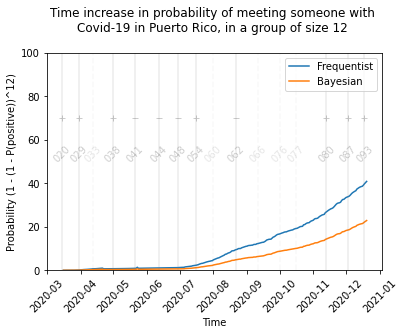

In [109]:
# Calculate daily probabilities by both approaches:

probs_12 = []
for index, row in df_test.iterrows(): 
  probs_12.append((1 - (1 - row['frequentist'])**12)*100)
for index, row in df_test.iterrows():
  probs_12.append((1 - (1 - row['bayesian'])**12)*100)

# Plot probabilites by time:

fig, ax = plt.subplots()
ax.plot(df_test['date'], probs_12[len(df_test['date']):])
ax.plot(df_test['date'], probs_12[:len(df_test['date'])])

# Set axis labels and title of the graph:

ax.set_xlabel("Time")
ax.set_ylabel("Probability (1 - (1 - P(positive))^12)")
ax.set_title('''Time increase in probability of meeting someone with 
Covid-19 in Puerto Rico, in a group of size 12 \n''')

# Set y-axis limits, rotate x-axis ticks and insert legend:

plt.ylim(0, 100)
plt.xticks(rotation = 45)
plt.legend(['Frequentist', 'Bayesian'])

# Show lines marking the date of each executive order, its ID # and whether
#   it increased ('+'), decreased ('_') or continued previous restrictions:

if show_EOs:
  for EO in More_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-' , color = 'grey', alpha = 0.15) 
    plt.plot(pd.to_datetime(EO[0]), 70, marker = '+', color = 'black', alpha = 0.20)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.20)
  for EO in Less_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-' , color = 'grey', alpha = 0.15)
    plt.plot(pd.to_datetime(EO[0]), 70, marker = '_', color = 'black', alpha = 0.20)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.20)
  for EO in Same_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '--', color = 'grey', alpha = 0.05)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.10)
    
# Show and close plot:

plt.show()
plt.close()

Plot the daily increase in the probability of coming into contact with someone with Covid-19 in a group of **size 50**:

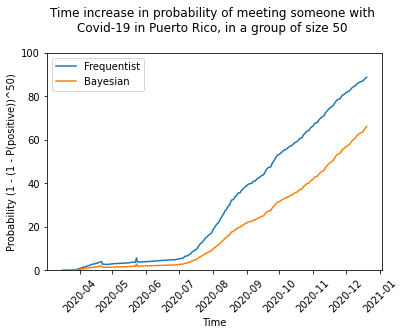

In [114]:
# Calculate daily probabilities by both approaches:

probs_50 = []
for index, row in df_test.iterrows(): 
  probs_50.append((1 - (1 - row['frequentist'])**50)*100)
for index, row in df_test.iterrows():
  probs_50.append((1 - (1 - row['bayesian'])**50)*100)

# Plot probabilites by time:

fig, ax = plt.subplots()
ax.plot(df_test['date'], probs_50[len(df_test['date']):])
ax.plot(df_test['date'], probs_50[:len(df_test['date'])])

# Set axis labels and title of the graph:

ax.set_xlabel("Time")
ax.set_ylabel("Probability (1 - (1 - P(positive))^50)")
ax.set_title('''Time increase in probability of meeting someone with 
Covid-19 in Puerto Rico, in a group of size 50 \n''')

# Set y-axis limits, rotate x-axis ticks and insert legend:

plt.ylim(0, 100)
plt.xticks(rotation = 45)
plt.legend(['Frequentist', 'Bayesian'])

# Show lines marking the date of each executive order, its ID # and whether
#   it increased ('+'), decreased ('_') or continued previous restrictions:

if show_EOs:
  for EO in More_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-' , color = 'grey', alpha = 0.15) 
    plt.plot(pd.to_datetime(EO[0]), 70, marker = '+', color = 'black', alpha = 0.20)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.20)
  for EO in Less_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '-' , color = 'grey', alpha = 0.15)
    plt.plot(pd.to_datetime(EO[0]), 70, marker = '_', color = 'black', alpha = 0.20)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.20)
  for EO in Same_restr_EO: 
    plt.axvline(pd.to_datetime(EO[0]), linestyle = '--', color = 'grey', alpha = 0.05)
    plt.text(pd.to_datetime(EO[0]), 50, EO[1], horizontalalignment = 'center', 
             rotation = 45, alpha = 0.10)
    
# Show and close plot:

plt.show()
plt.close()

## References:

* Source article of the main probability formulas used in this project:

  * ["How likely are you to meet someone with Coronavirus?"](https://towardsdatascience.com/how-likely-are-you-to-meet-someone-with-coronavirus-4522d39487b7), by Marek Galovič

* Datasets:

  * [Coronavirus Resource Center](https://coronavirus.jhu.edu/region/us/puerto-rico) of the John Hopkins University of Medicine
  * [Centers of Desease Control and Prevention](https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36)

* [Repository of all referenced executive orders](https://www.estado.pr.gov/en/executive-orders/) provided by the Government of Puerto Rico.